# Imports

In [1]:
import sys
sys.path.append('..')

from src.utils import calculate_volatility, prepare_volatility_data, plot_ticker_volatility
import pandas as pd
import os
import re
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math


For this notebook, we will take a look at the stock prices for our group of tickers over the project timeframe and will look for any odd patterns, inconsistencies and anything that may need to be accounted for in the modeling stage.

# Read in Data

## Prices

In [2]:
df = pd.read_csv('../data/raw/historical_prices.csv')

In [3]:
df

,symbol,date,open,low,high,close,adjClose,volume
0,SAVE,2018-01-02 00:00:00,44.700000,44.090000,45.610000,45.600000,42.690000,899200.0
1,A1G.DE,2018-01-02 00:00:00,43.292500,43.292500,43.292500,43.292500,43.023121,0.0
2,GLUX,2018-01-02 00:00:00,0.150700,0.150700,0.155650,0.155650,0.155650,11136.0
3,SWN.DE,2018-01-02 00:00:00,54.419998,54.419998,54.419998,54.419998,53.993729,0.0
4,HRBR,2018-01-02 00:00:00,0.020000,0.010000,0.020000,0.020000,0.020000,40600.0
...,...,...,...,...,...,...,...,...
27189,ALGT,2023-12-19 00:00:00,83.750000,82.920000,84.780000,83.460000,83.460000,213155.0
27190,HA,2023-12-19 00:00:00,13.800000,13.540000,13.950000,13.540000,13.540000,1111400.0
27191,DAL,2023-12-19 00:00:00,41.420000,41.060000,41.710000,41.150000,41.150000,7559963.0
27192,SNCY,2023-12-19 00:00:00,15.920000,15.870000,16.250000,16.140000,16.140000,435826.0


## Transcripts

In [4]:
data_directory = '../data/raw/'
transcript_files = glob.glob(os.path.join(data_directory, '*_transcripts.json'))

all_transcripts = []

# read all the files in the directory
for file in transcript_files:
    transcript_df = pd.read_json(file)
    all_transcripts.append(transcript_df)
# combine into one df
combined_transcripts_df = pd.concat(all_transcripts, ignore_index=True)
combined_transcripts_df.head()

,symbol,quarter,year,date,content
0,AAL,3,2023,2023-10-19 12:37:10,Operator: Thank you for standing by and welcom...
1,AAL,2,2023,2023-07-20 11:51:04,"Operator: Thank you for standing by, and welco..."
2,AAL,1,2023,2023-04-27 11:15:04,"Operator: Thank you for standing by, and welco..."
3,AAL,4,2022,2023-01-26 12:53:07,"Operator: Thank you for standing by, and welco..."
4,AAL,3,2022,2022-10-20 14:26:04,"Operator: Thank you for standing by, and welco..."


In [5]:
# dropping the tickers that did not have transcripts available
tickers_to_drop = ['A1G.DE','GLUX','SWN.DE','JET.NE','SRFM']
df = df[~df['symbol'].isin(tickers_to_drop)]

# Visualizations

## Closing stock prices

C:\Users\jbrad\AppData\Local\Temp\ipykernel_9144\4241992753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


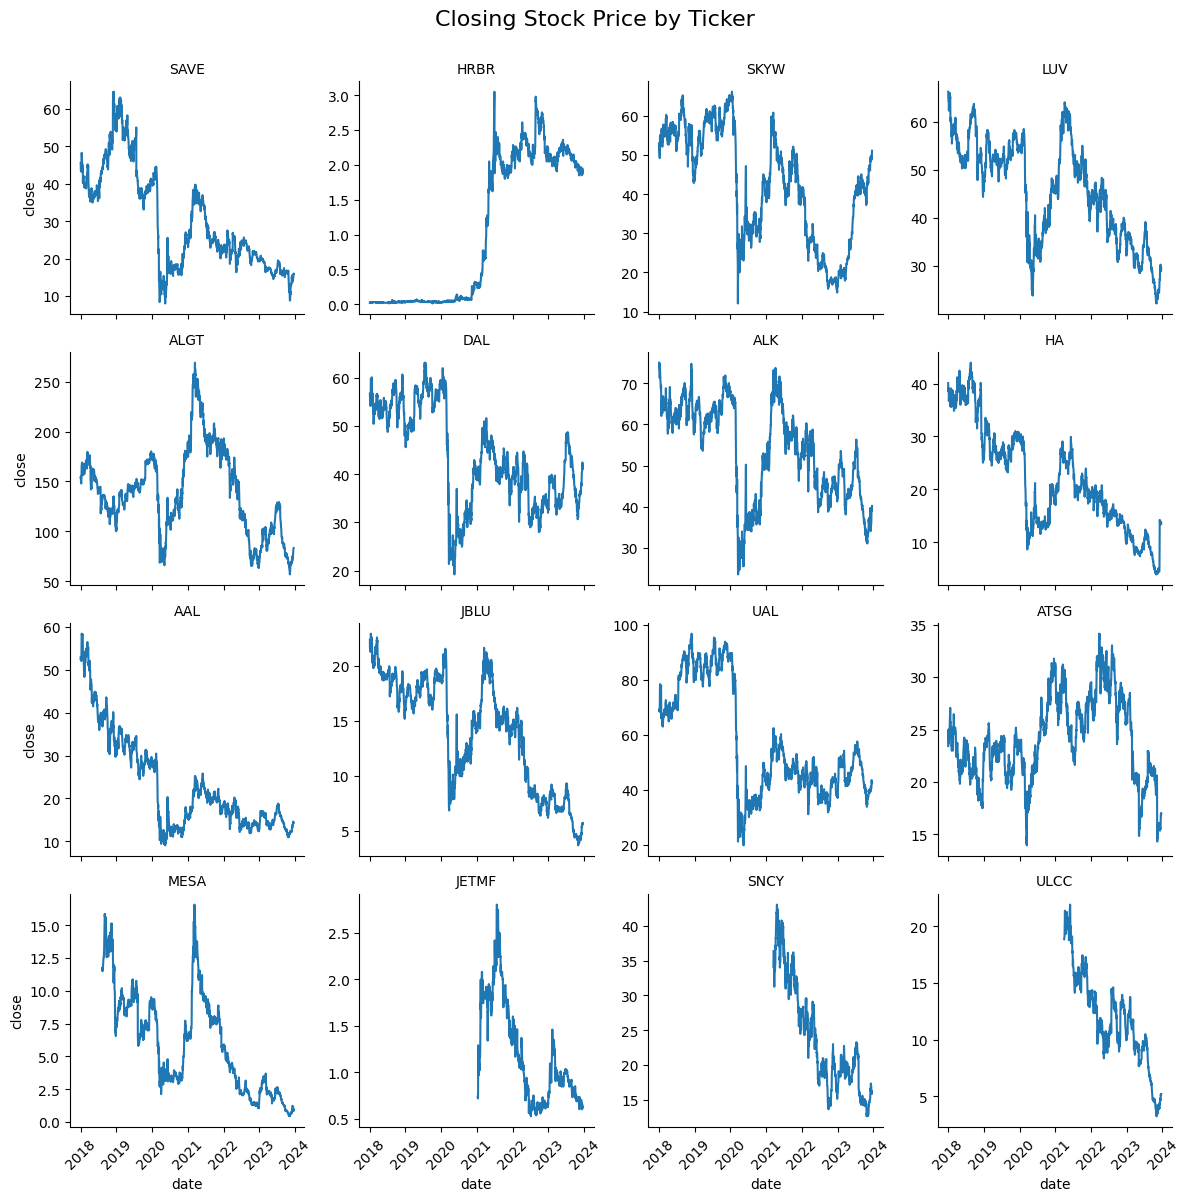

In [6]:
df['date'] = pd.to_datetime(df['date'])
# Create a FacetGrid and lineplot
g = sns.FacetGrid(df, col="symbol", col_wrap=4, height=3, sharey=False)
g = g.map(plt.plot, "date", "close")

# Set titles and adjust x-axis labels
g.fig.suptitle('Closing Stock Price by Ticker', fontsize=16)
g.fig.subplots_adjust(top=0.92)  # adjust the top height so the title is above the grids
g.set_titles("{col_name}")
for ax in g.axes:
    plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

## Volume

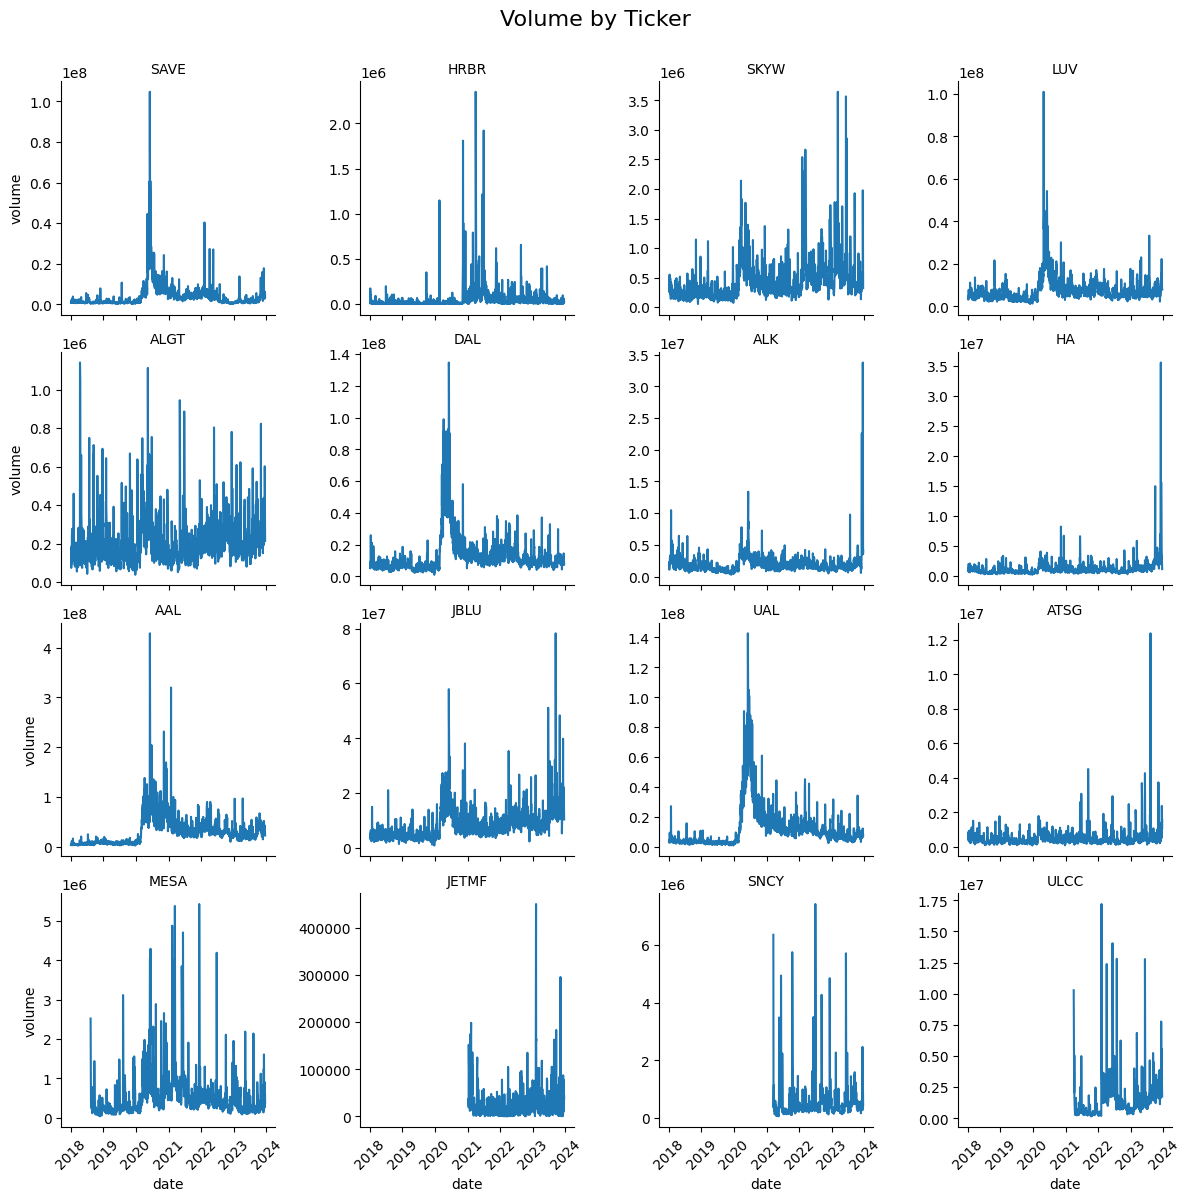

In [7]:
# Create a FacetGrid and lineplot
g = sns.FacetGrid(df, col="symbol", col_wrap=4, height=3, sharey=False)
g = g.map(plt.plot, "date", "volume")

# Set titles and adjust x-axis labels
g.fig.suptitle('Volume by Ticker', fontsize=16)
g.fig.subplots_adjust(top=0.92)  # adjust the top height so the title is above the grids
g.set_titles("{col_name}")
for ax in g.axes:
    plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

In [8]:
df.head()

,symbol,date,open,low,high,close,adjClose,volume
0,SAVE,2018-01-02,44.70,44.09,45.61,45.60,42.69,899200.0
4,HRBR,2018-01-02,0.02,0.01,0.02,0.02,0.02,40600.0
6,SKYW,2018-01-02,53.10,52.73,53.30,53.00,51.89,361000.0
7,LUV,2018-01-02,65.91,65.51,66.37,66.29,63.08,3791500.0
8,ALGT,2018-01-02,155.40,148.16,157.00,154.05,145.10,171600.0


## Standard Deviation of Closing Prices

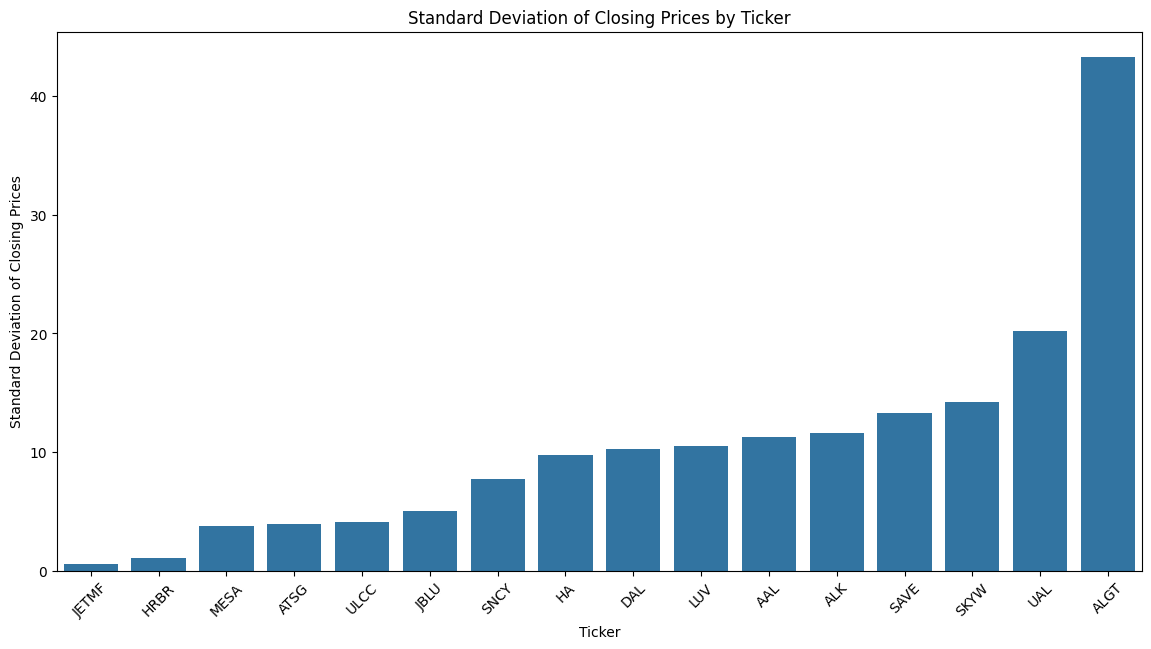

In [9]:
# Calculate standard deviation of closing prices for each ticker
std_devs = df.groupby('symbol')['close'].std().reset_index(name='standard_deviation_prices')

sorted_std_devs = std_devs.sort_values('standard_deviation_prices')
plt.figure(figsize=(14, 7))
sns.barplot(x='symbol', y='standard_deviation_prices', data=sorted_std_devs)
plt.title('Standard Deviation of Closing Prices by Ticker')
plt.xlabel('Ticker')
plt.ylabel('Standard Deviation of Closing Prices')
plt.xticks(rotation=45)
plt.show()

## Standard Deviation of Daily Returns

Looking at the volatility by ticker, many of the larger established names in the space are showing similar volatility readings, with the outliers being some of the smaller names in the industry. 

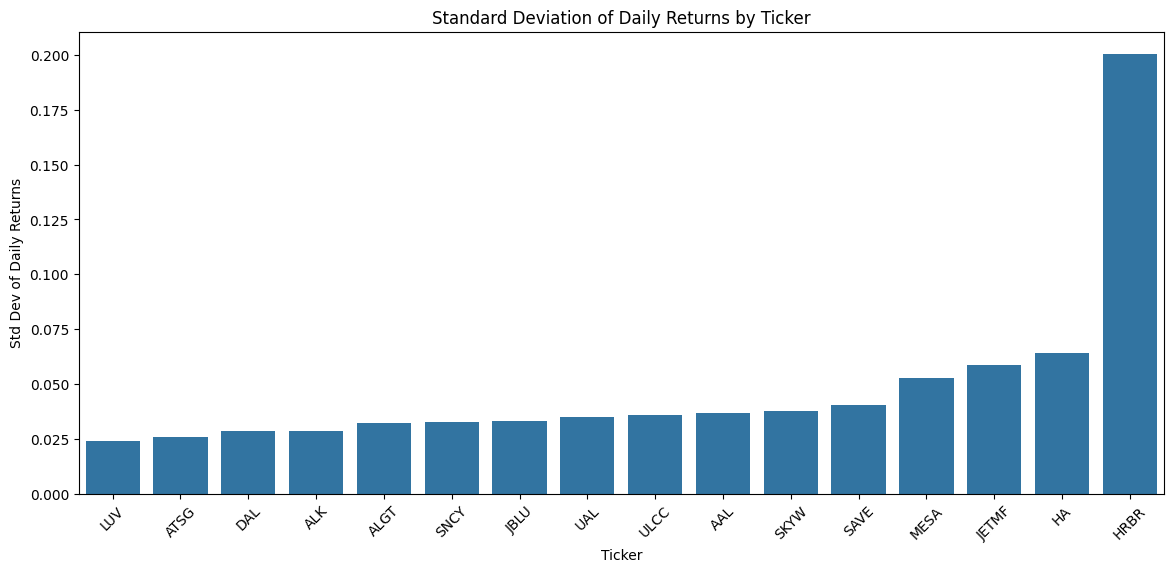

In [10]:
df = df.copy()
df.loc[:, 'daily_return'] = df.groupby('symbol')['close'].pct_change()
df.dropna(subset=['daily_return'], inplace=True)

# Calculate the standard deviation of daily returns for each stock
volatility = df.groupby('symbol')['daily_return'].std().dropna().to_frame('standard_deviation_daily_returns')

# Plot the volatility for each stock
volatility_sorted = volatility.sort_values(by='standard_deviation_daily_returns')
plt.figure(figsize=(14, 6))
sns.barplot(x=volatility_sorted.index, y='standard_deviation_daily_returns', data=volatility_sorted)
plt.title('Standard Deviation of Daily Returns by Ticker')
plt.xlabel('Ticker')
plt.ylabel('Std Dev of Daily Returns')
plt.xticks(rotation=45)
plt.show()

## Correlation of Daily Returns

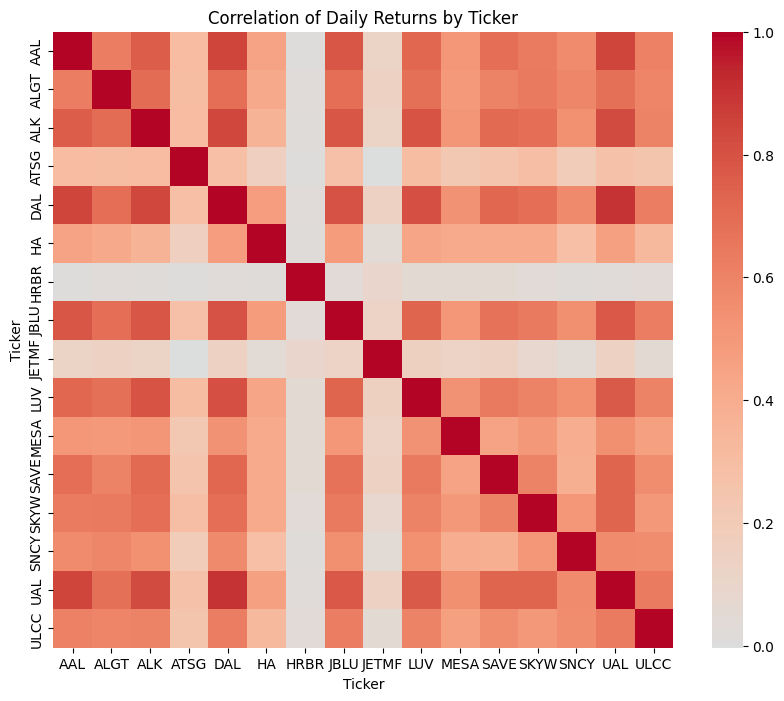

In [11]:
# Create a pivot table with dates as the index and symbols as the columns, filled with daily returns
pivot_daily_returns = df.pivot_table(index='date', columns='symbol', values='daily_return')

# Calculate the correlation matrix for daily returns
corr_daily_return = pivot_daily_returns.corr(min_periods=1)

# Plot the correlation matrix of daily returns

plt.figure(figsize=(10, 8))
sns.heatmap(corr_daily_return, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation of Daily Returns by Ticker')
plt.xlabel('Ticker')
plt.ylabel('Ticker')
plt.show()

## Volatility Around Earnings

What I wanted to do here is to look at the volatility of a stock price around the earnings call. So I chose 5 days before and 5 days after as my starting point. With the exception of 2020 around the early days of Covid, most of the periods saw higher volatility after the call, with several of the smaller cap stocks showing higher volatility as expected. 

No volatility data to plot for HRBR


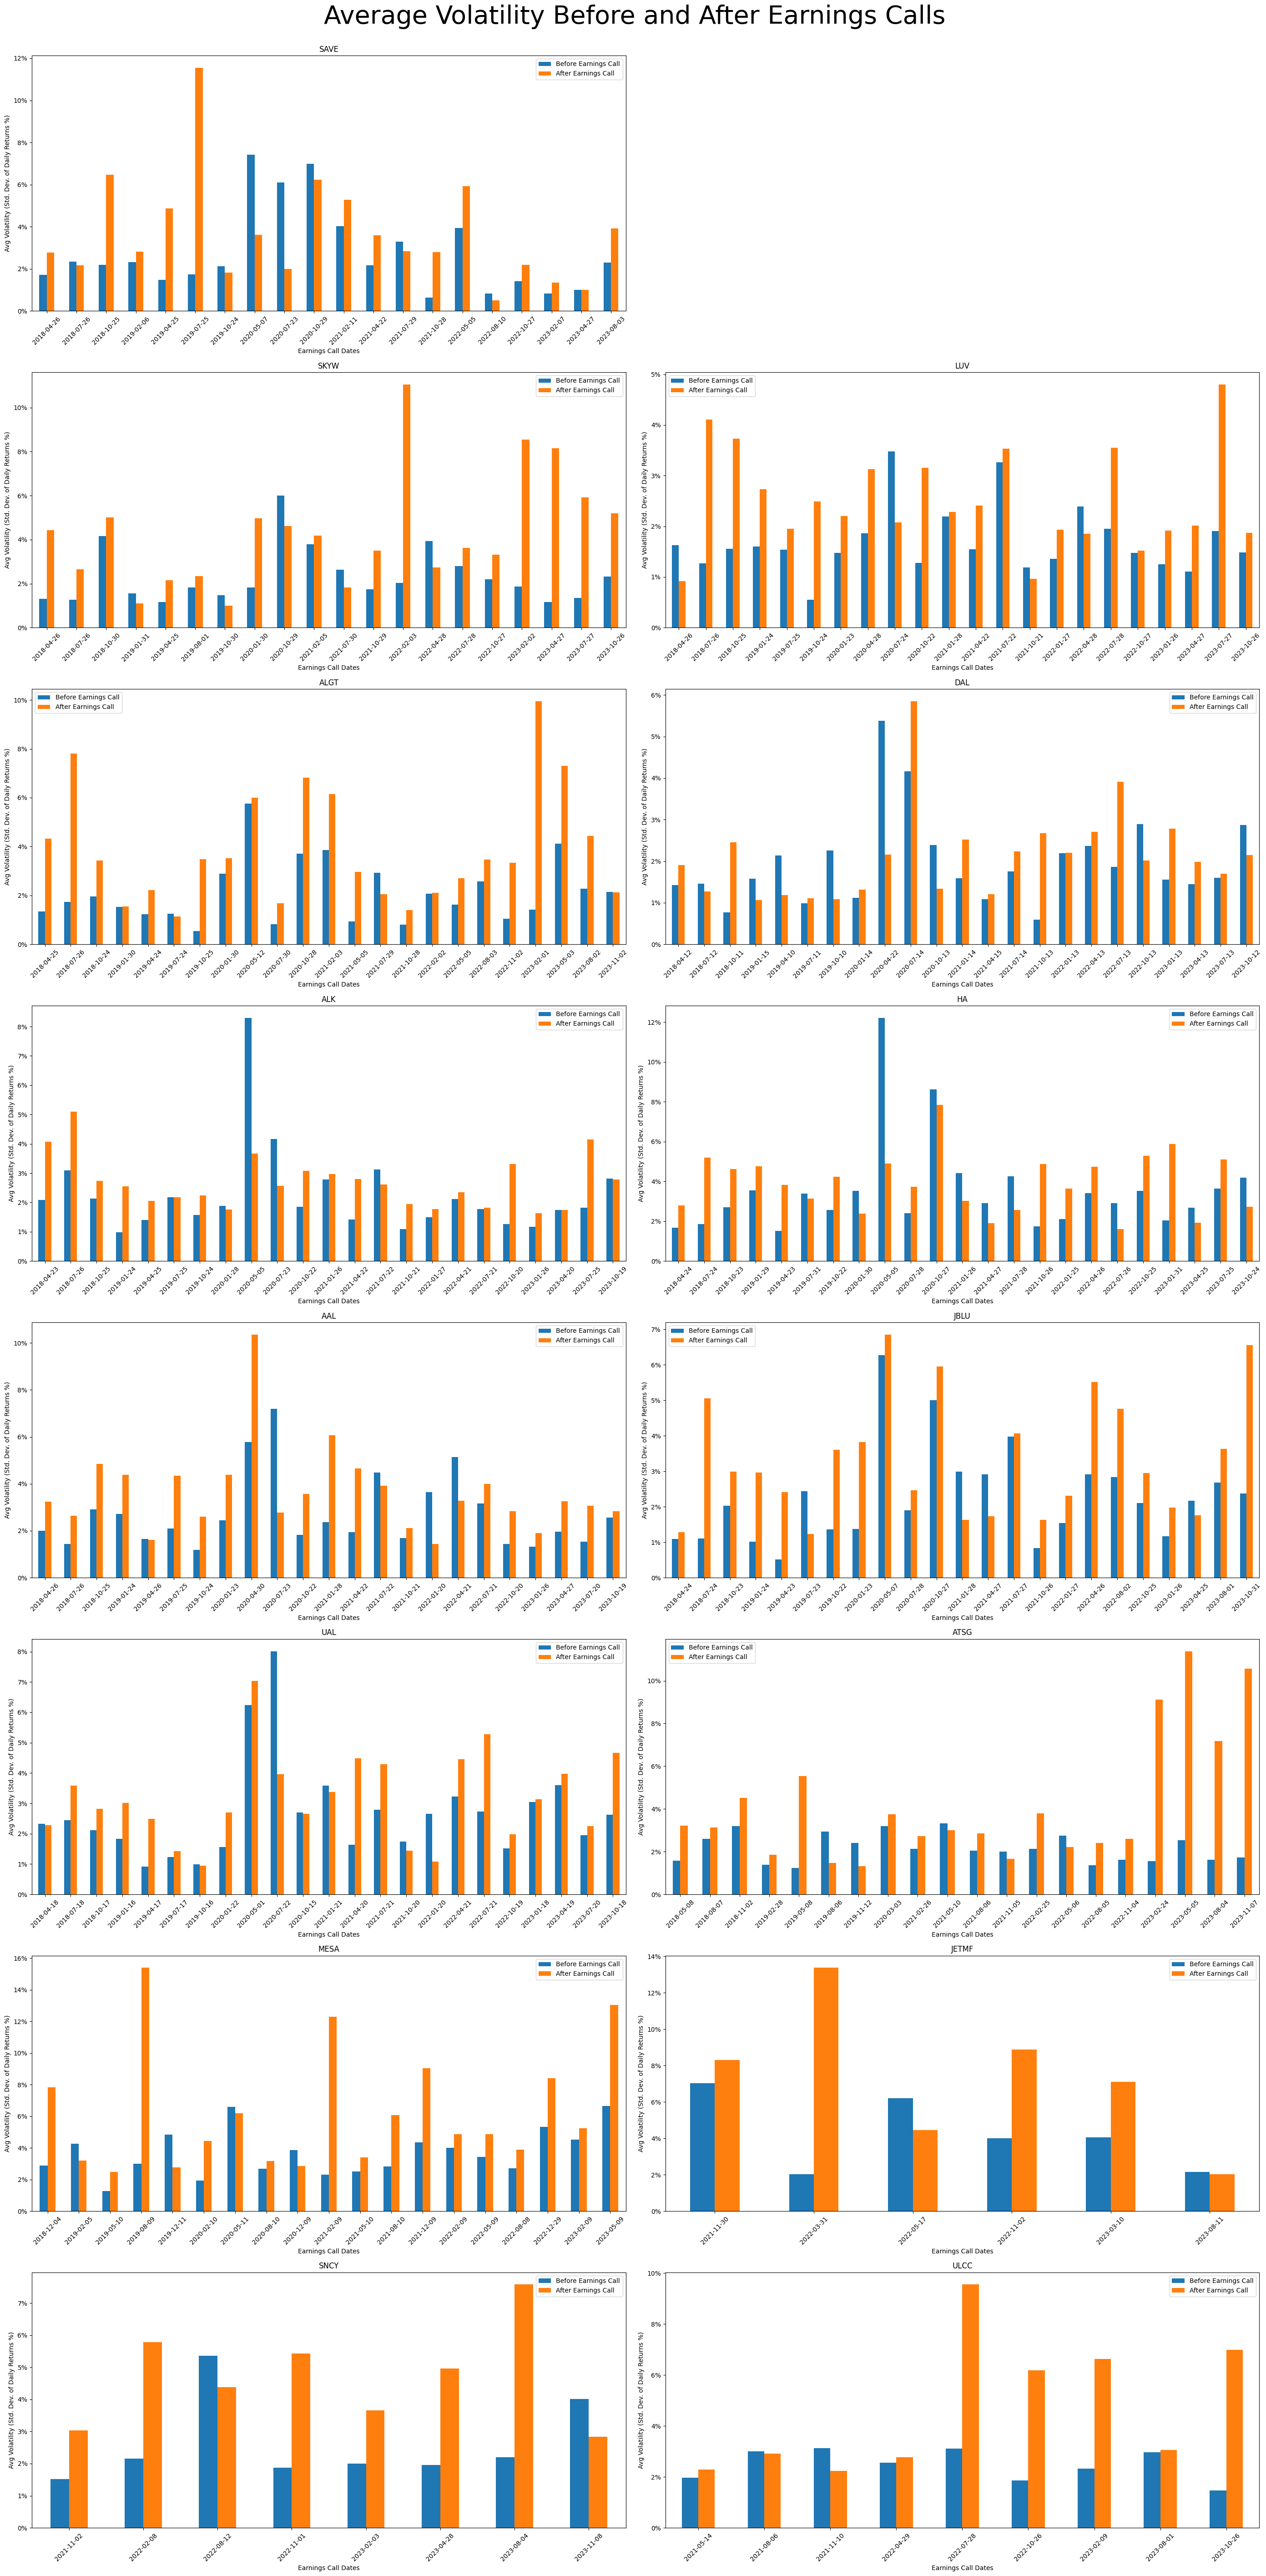

In [12]:
# combine the transcript and price data together in a single df
combined_transcripts_df['date'] = pd.to_datetime(combined_transcripts_df['date']).dt.normalize()
combined_df = df.merge(combined_transcripts_df, how='left', on=['symbol','date'])

# Calculate volatility
df.loc[:, 'volatility'] = df.groupby('symbol')['daily_return'].transform(lambda x: calculate_volatility(x))
df = df.dropna(subset=['volatility'])

# Setup for subplots
subplots_per_row = 2
unique_tickers = combined_df['symbol'].unique()
total_plots = len(unique_tickers)
total_rows = math.ceil(total_plots / subplots_per_row)
fig, axes = plt.subplots(total_rows, subplots_per_row, figsize=(14 * subplots_per_row, 7 * total_rows), squeeze=False)
axes = axes.flatten()

# Loop through the tickers and create a plot for each one
for idx, ticker in enumerate(unique_tickers):
    call_dates = combined_df[(combined_df['symbol'] == ticker) & ~(combined_df['content'].isna())]['date']
    
    # Prepare the volatility data
    summarized_volatility_df = prepare_volatility_data(df, ticker, call_dates)
    
    # If the df is not empty, proceed with plotting
    if not summarized_volatility_df.empty:
        summarized_volatility_df['date'] = pd.to_datetime(summarized_volatility_df['date']).dt.date
        # set date as index for plotting
        summarized_volatility_df.set_index('date', inplace=True)
        plot_ticker_volatility(axes[idx], summarized_volatility_df, ticker)
    else:
        print(f"No volatility data to plot for {ticker}")
        axes[idx].set_visible(False) # hide if no data

# Set overall title and adjust layout
fig.suptitle('Average Volatility Before and After Earnings Calls', fontsize=40, y=1.01)
plt.tight_layout()
plt.subplots_adjust(top=0.99) # give a little spacing

# Remove unused subplots
for idx in range(total_plots, len(axes)):
    fig.delaxes(axes[idx])
plt.show()